# ISY5002 PSUPR/PRMLS CA1
### Dataset is sourced from https://www.kaggle.com/devinanzelmo/dota-2-matches



##### Name: Raymond Ng Boon Cheong  
##### Student ID: A0198543R

##### Import dependencies

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import uniform, randint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn import metrics
import time

import warnings
warnings.filterwarnings('ignore')

In [11]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [12]:
heros = pd.read_csv('../dataset/hero_names.csv')
matches = pd.read_csv('../dataset/match.csv')
players = pd.read_csv('../dataset/players.csv')

In [13]:
players.head()

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
0,0,0,86,0,3261,10960,347,362,9,3,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,51,1,2954,17760,494,659,13,3,...,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,83,2,110,12195,350,385,0,4,...,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,11,3,1179,22505,599,605,8,4,...,1.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3,67,4,3307,23825,613,762,20,3,...,3.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
heros_dict = dict(zip(heros['hero_id'], heros['localized_name']))
heros_dict[0] = 'None'

In [15]:
prep = pd.DataFrame()
prep['hero'] = players['hero_id'].apply(lambda id: heros_dict[id])

In [16]:
prep.head()

,hero
0,Rubick
1,Clockwerk
2,Treant Protector
3,Shadow Fiend
4,Spectre


In [17]:
prep.shape

(500000, 1)

In [18]:
players_heroes = pd.get_dummies(prep['hero'])
players_heroes.head()

,Abaddon,Alchemist,Ancient Apparition,Anti-Mage,Axe,Bane,Batrider,Beastmaster,Bloodseeker,Bounty Hunter,...,Venomancer,Viper,Visage,Warlock,Weaver,Windranger,Winter Wyvern,Witch Doctor,Wraith King,Zeus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
players_heroes.shape

(500000, 111)

In [20]:
players_lvl_xp = {
    'level': players['level'],
    'xp_hero': players['xp_hero'],
    'xp_creep': players['xp_creep']
}
players_lvl_xp_labels = players_lvl_xp.keys()

p_lvl_xp = pd.DataFrame(players_lvl_xp, columns=players_lvl_xp_labels)
p_lvl_xp.fillna(0)

,level,xp_hero,xp_creep
0,16,8840.0,5440.0
1,22,14331.0,8440.0
2,17,6692.0,8112.0
3,21,8583.0,14230.0
4,24,15814.0,14325.0
...,...,...,...
499995,23,21496.0,6025.0
499996,23,16360.0,9653.0
499997,18,8205.0,10012.0
499998,25,11773.0,20005.0


In [21]:
r_heroes_cols = list(map(lambda title: 'r_' + str(title), players_heroes.columns.values))
d_heroes_cols = list(map(lambda title: 'd_' + str(title), players_heroes.columns.values))
r_lvl_cols = list(map(lambda title: 'r_' + str(title), p_lvl_xp.columns.values))
d_lvl_cols = list(map(lambda title: 'd_' + str(title), p_lvl_xp.columns.values))

In [22]:
r_hero_list = []
d_hero_list = []
r_lvl_xp_list = []
d_lvl_xp_list = []

for id, idx in players.groupby('match_id').groups.items():
    r_hero_list.append(players_heroes.iloc[idx][:5].sum().values)
    d_hero_list.append(players_heroes.iloc[idx][5:].sum().values)
    r_lvl_xp_list.append(p_lvl_xp.iloc[idx][:5].sum().values)
    d_lvl_xp_list.append(p_lvl_xp.iloc[idx][5:].sum().values)

In [23]:
r_heroes = pd.DataFrame(r_hero_list, columns=r_heroes_cols)
d_heroes = pd.DataFrame(d_hero_list, columns=d_heroes_cols)
r_lvl_xp = pd.DataFrame(r_lvl_xp_list, columns=r_lvl_cols)
d_lvl_xp = pd.DataFrame(d_lvl_xp_list, columns=d_lvl_cols)

X = pd.DataFrame()
X = pd.concat([r_heroes, d_heroes, r_lvl_xp, d_lvl_xp], axis=1)

In [24]:
X.shape

(50000, 228)

In [25]:
X.head()

,r_Abaddon,r_Alchemist,r_Ancient Apparition,r_Anti-Mage,r_Axe,r_Bane,r_Batrider,r_Beastmaster,r_Bloodseeker,r_Bounty Hunter,...,d_Winter Wyvern,d_Witch Doctor,d_Wraith King,d_Zeus,r_level,r_xp_hero,r_xp_creep,d_level,d_xp_hero,d_xp_creep
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,100.0,54260.0,50547.0,84.0,32013.0,49581.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,92.0,35143.0,38193.0,111.0,61636.0,69377.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,80.0,21155.0,50575.0,99.0,53410.0,49894.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,110.0,84107.0,43763.0,112.0,84889.0,46794.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,85.0,31029.0,45444.0,65.0,19392.0,29549.0


In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 228 entries, r_Abaddon to d_xp_creep
dtypes: float64(6), int64(222)
memory usage: 87.0 MB


In [27]:
X.describe()

,r_Abaddon,r_Alchemist,r_Ancient Apparition,r_Anti-Mage,r_Axe,r_Bane,r_Batrider,r_Beastmaster,r_Bloodseeker,r_Bounty Hunter,...,d_Winter Wyvern,d_Witch Doctor,d_Wraith King,d_Zeus,r_level,r_xp_hero,r_xp_creep,d_level,d_xp_hero,d_xp_creep
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.033720,0.099260,0.067620,0.092740,0.045820,0.02560,0.009960,0.012980,0.029980,0.067040,...,0.076360,0.073400,0.077760,0.04658,90.329780,43823.015720,47339.758200,90.192120,43494.625000,47368.940200
std,0.180509,0.299014,0.251095,0.290071,0.209097,0.15794,0.099303,0.113189,0.170534,0.250094,...,0.265576,0.260795,0.267796,0.21074,16.949911,19043.371723,14220.061224,18.179635,19897.499796,14580.644952
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,5.000000,0.000000,62.000000,6.000000,0.000000,308.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,79.000000,29793.500000,36828.750000,78.000000,28562.000000,36613.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,91.000000,42920.000000,46272.500000,92.000000,43089.500000,46660.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,103.000000,57065.250000,56815.250000,104.000000,57675.750000,57266.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,125.000000,117609.000000,115026.000000,125.000000,113282.000000,116644.000000


In [28]:
X.corr()

,r_Abaddon,r_Alchemist,r_Ancient Apparition,r_Anti-Mage,r_Axe,r_Bane,r_Batrider,r_Beastmaster,r_Bloodseeker,r_Bounty Hunter,...,d_Winter Wyvern,d_Witch Doctor,d_Wraith King,d_Zeus,r_level,r_xp_hero,r_xp_creep,d_level,d_xp_hero,d_xp_creep
r_Abaddon,1.000000,-0.013470,-0.018095,-0.003193,-0.006493,-0.012741,0.001347,-0.007718,-0.011400,-0.009317,...,-0.002396,0.001380,-0.002111,-0.009744,-0.025769,-0.026269,-0.022400,-0.039091,-0.046028,-0.023203
r_Alchemist,-0.013470,1.000000,-0.003090,-0.040646,-0.010686,-0.007645,-0.004332,-0.003794,-0.005801,-0.002599,...,-0.015609,-0.005459,0.000019,-0.008308,-0.008692,-0.029316,0.034614,0.009807,-0.000217,0.013178
r_Ancient Apparition,-0.018095,-0.003090,1.000000,0.000122,-0.003397,-0.019443,-0.005354,0.008525,-0.008577,-0.019957,...,0.012245,0.003920,-0.003244,-0.006987,0.026199,0.025824,0.031321,0.021677,0.002188,0.045034
r_Anti-Mage,-0.003193,-0.040646,0.000122,1.000000,-0.001473,0.001874,0.003344,-0.006206,-0.014967,-0.010715,...,0.003873,-0.006704,0.069627,0.010800,-0.019775,-0.074794,0.073881,0.005712,-0.013046,0.017188
r_Axe,-0.006493,-0.010686,-0.003397,-0.001473,1.000000,-0.005844,-0.003678,-0.011609,-0.015528,-0.014759,...,-0.015466,-0.001159,-0.009340,-0.002594,0.004619,0.004133,0.007454,0.021056,0.034784,0.000317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
r_xp_hero,-0.026269,-0.029316,0.025824,-0.074794,0.004133,-0.018126,0.005203,-0.004824,0.033047,-0.011236,...,-0.035115,-0.003611,-0.061602,0.009048,0.916311,1.000000,0.620027,0.619645,0.610999,0.543491
r_xp_creep,-0.022400,0.034614,0.031321,0.073881,0.007454,-0.004115,0.003213,-0.006973,0.025298,-0.030058,...,-0.010053,0.007871,-0.028287,0.021317,0.859789,0.620027,1.000000,0.719024,0.570904,0.803381
d_level,-0.039091,0.009807,0.021677,0.005712,0.021056,-0.007153,0.009797,0.002345,0.038998,-0.026359,...,-0.021465,0.002986,-0.006733,0.043098,0.716585,0.619645,0.719024,1.000000,0.923071,0.874472
d_xp_hero,-0.046028,-0.000217,0.002188,-0.013046,0.034784,-0.007747,0.009799,-0.005440,0.052709,-0.008596,...,-0.021476,0.013532,-0.003875,0.053774,0.638826,0.610999,0.570904,0.923071,1.000000,0.656259


In [29]:
y_arr = OrdinalEncoder().fit_transform(matches['radiant_win'].values.reshape(-1,1))
col = ['r_win']
y = pd.DataFrame(y_arr, columns=col)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1st attempt
Try a simple LinearSVC model with default parameters to get an initial result

In [31]:
cal_svc = CalibratedClassifierCV(
            base_estimator=LinearSVC(
                random_state=42, 
                C=10, 
                max_iter=1500, 
                verbose=False), 
            method='sigmoid', cv=5)

In [32]:
start = time.time()
cal_svc.fit(X_train, y_train)
end = time.time()
print('Elapsed: ' + str(end-start))

Elapsed: 26.07870388031006


In [33]:
y_pred = cal_svc.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[4371  444]
 [ 370 4815]]
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      4815
         1.0       0.92      0.93      0.92      5185

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [34]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.9186


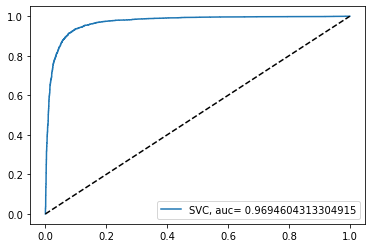

In [35]:
y_pred_proba = cal_svc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

### 1st attempt summary
Using a linear SVM with default parameters, the accuracy achieved is already good at 91.86%

### 2nd attempt
Try to improve further by normalizing the input data

In [36]:
scale_pipe = Pipeline([
    ('norm', Normalizer()),
    ('cal_linsvc', CalibratedClassifierCV(
                    base_estimator=LinearSVC(
                        random_state=42,
                        C=10.0,
                        max_iter=1500,
                        verbose=False),
                    cv=10,
                    method='sigmoid'))
])

In [37]:
start = time.time()
scale_pipe.fit(X_train, y_train)
end = time.time()
print('Elapsed: ' + str(end-start))

Elapsed: 12.156528234481812


In [38]:
X_test_scale = Normalizer().fit_transform(X_test)
y_pred = scale_pipe.predict(X_test_scale)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[4422  393]
 [ 360 4825]]
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      4815
         1.0       0.92      0.93      0.93      5185

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [39]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.9247


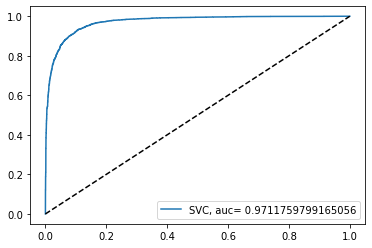

In [40]:
y_pred_proba = cal_svc.predict_proba(X_test_scale)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

### 2nd attempt summary
After normalizing the data, a slight improvement to 92.47% accuracy could be observed

### 3rd attempt
Try to search for the best hyperparameter with a random search

In [41]:
params = {
    'cal_linsvc__base_estimator__C': [0.1, 1.0, 10, 100, 1000],
    'cal_linsvc__base_estimator__max_iter': [1000, 3000, 5000, 10000],
    'cal_linsvc__cv': [5, 10, 15]
}

In [42]:
scale_pipe = Pipeline([
    ('norm', Normalizer()),
    ('cal_linsvc', CalibratedClassifierCV(
                    base_estimator=LinearSVC(
                        random_state=42,
                        C=10.0,
                        max_iter=1500,
                        verbose=False),
                    cv=10,
                    method='sigmoid'))
])

rs = RandomizedSearchCV(
    estimator=scale_pipe,
    random_state=42,
    n_jobs=-1,
    cv=10,
    param_distributions=params)

In [43]:
start = time.time()
rs.fit(X_train, y_train)
end = time.time()
print('Elapsed: ' + str(end-start))

Elapsed: 725.2456760406494


In [44]:
X_test_scale = Normalizer().fit_transform(X_test)
y_pred = rs.predict(X_test_scale)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[4423  392]
 [ 358 4827]]
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      4815
         1.0       0.92      0.93      0.93      5185

    accuracy                           0.93     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.93      0.92     10000



In [45]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.925


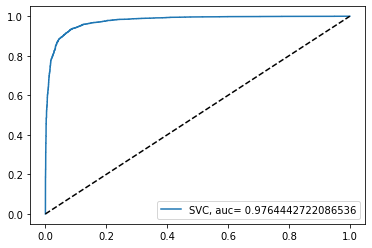

In [46]:
y_pred_proba = rs.predict_proba(X_test_scale)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

In [47]:
rs.best_estimator_

Pipeline(memory=None,
         steps=[('norm', Normalizer(copy=True, norm='l2')),
                ('cal_linsvc',
                 CalibratedClassifierCV(base_estimator=LinearSVC(C=1000,
                                                                 class_weight=None,
                                                                 dual=True,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 loss='squared_hinge',
                                                                 max_iter=5000,
                                                                 multi_class='ovr',
                                                                 penalty='l2',
                                                                 random_state=42,
                                                                 tol=0.

In [48]:
rs.best_params_

{'cal_linsvc__cv': 5,
 'cal_linsvc__base_estimator__max_iter': 5000,
 'cal_linsvc__base_estimator__C': 1000}

### 3rd attempt summary
After performing a random search for optimal hyperparameters, accuracy improved very slightly by 0.001%

### 4th attempt
Train the dataset with a Gradient Boosting ensemble model and compare result with model above

In [49]:
gboost_norm_pipe = Pipeline([
    ('norm', Normalizer()),
    ('gboost', GradientBoostingClassifier())
])

In [50]:
start = time.time()
gboost_norm_pipe.fit(X_train, y_train)
end = time.time()
print('Elapsed: ' + str(end-start))

Elapsed: 23.490066051483154


In [51]:
X_test_scale = Normalizer().fit_transform(X_test)
y_pred = gboost_norm_pipe.predict(X_test_scale)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[4470  345]
 [ 321 4864]]
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      4815
         1.0       0.93      0.94      0.94      5185

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [52]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.9334


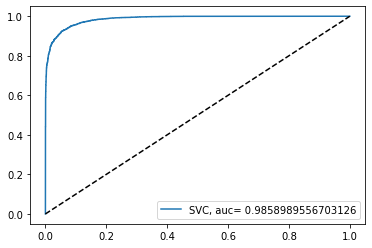

In [53]:
y_pred_proba = gboost_norm_pipe.predict_proba(X_test_scale)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

### 4th attempt summary
Using a gradient boosting ensemble model with default parameters, the accuracy achieved is already quite good at 93.34%.
This shows that an gradient boost ensemble model with untune hyperparameters could out performed a tune LinearSVC model for this dataset.

### 5th attempt
Fine tune gradient boosting hyperparameters with a random search

In [54]:
params = {
    'gboost__learning_rate': uniform(0.01, 10.0),
    'gboost__n_estimators': randint(10, 1000),
    'gboost__min_samples_split': randint(2, 10),
    'gboost__min_samples_leaf': randint(3, 10),
    'gboost__max_depth': randint(3,10),
    'gboost__max_features': ('auto', 'sqrt', 'log2')
}

In [55]:
gboost_norm_pipe = Pipeline([
    ('norm', Normalizer()),
    ('gboost', GradientBoostingClassifier(
                random_state=42, 
                verbose=False))
])

gs_gboost = RandomizedSearchCV(
                gboost_norm_pipe, 
                param_distributions=params,
                random_state=42,
                n_jobs=-1, cv=5)
gs_gboost.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__norm', 'estimator__gboost', 'estimator__norm__copy', 'estimator__norm__norm', 'estimator__gboost__criterion', 'estimator__gboost__init', 'estimator__gboost__learning_rate', 'estimator__gboost__loss', 'estimator__gboost__max_depth', 'estimator__gboost__max_features', 'estimator__gboost__max_leaf_nodes', 'estimator__gboost__min_impurity_decrease', 'estimator__gboost__min_impurity_split', 'estimator__gboost__min_samples_leaf', 'estimator__gboost__min_samples_split', 'estimator__gboost__min_weight_fraction_leaf', 'estimator__gboost__n_estimators', 'estimator__gboost__n_iter_no_change', 'estimator__gboost__presort', 'estimator__gboost__random_state', 'estimator__gboost__subsample', 'estimator__gboost__tol', 'estimator__gboost__validation_fraction', 'estimator__gboost__verbose', 'estimator__gboost__warm_start', 'estimator', 'iid', 'n_iter', 'n_jobs', 'param_distributions', 'pre_dispatch

In [56]:
start = time.time()
gs_gboost.fit(X_train, y_train)
end = time.time()
print('Elapsed: ' + str(end-start))

Elapsed: 2869.8277485370636


In [57]:
X_test_scale = Normalizer().fit_transform(X_test)
y_pred = gs_gboost.predict(X_test_scale)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[4494  321]
 [ 317 4868]]
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      4815
         1.0       0.94      0.94      0.94      5185

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [58]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.9362


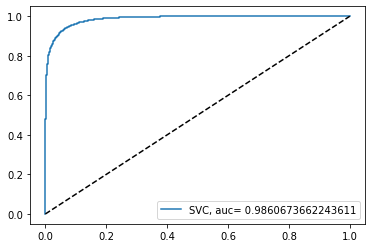

In [59]:
y_pred_proba = gs_gboost.predict_proba(X_test_scale)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

In [60]:
gs_gboost.best_estimator_

Pipeline(memory=None,
         steps=[('norm', Normalizer(copy=True, norm='l2')),
                ('gboost',
                 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                            learning_rate=0.24062425041415758,
                                            loss='deviance', max_depth=5,
                                            max_features='log2',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=9,
                                            min_samples_split=3,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=485,
                                            n_iter_no_change=None,
                                            presort='au

In [61]:
gs_gboost.best_params_

{'gboost__learning_rate': 0.24062425041415758,
 'gboost__max_depth': 5,
 'gboost__max_features': 'log2',
 'gboost__min_samples_leaf': 9,
 'gboost__min_samples_split': 3,
 'gboost__n_estimators': 485}

### 5th attempt summary
After a random search for optimal hyperparameter, the accuracy increased 0.03% compared to the default parameters.